In [113]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import curve_fit
import json


In [80]:
def gaussian(x, a, b, x0, sigma):
    return b + a*np.exp(-(x-x0)**2 / (2.0*sigma**2))

def fit_central_positions(img, ybin):
    xpos = []
    ypos = []
    xaxis = np.arange(img.shape[1])
    for i in range(0, img.shape[0]-ybin, ybin):
        profile = np.mean(img[i:i+ybin], axis=0)
        p0 = [np.amax(profile), 1, np.argmax(profile), 10]
        try:
            popt, _ = curve_fit(gaussian, xaxis, profile, p0=p0)
            xpos.append(popt[2])
            ypos.append(i + 0.5*ybin)
        except:
            pass
    return xpos, ypos

def fit_correction(img):
    xpos, ypos = fit_central_positions(img, 30)
    coef = np.polyfit(ypos, xpos, 2)
    poly = np.poly1d(coef)
    return poly


In [81]:
# fh = h5py.File("../data/NbO2_Kb13_76_data_000001.h5")
# fh["/entry/data/data"]
# img = fh["/entry/data/data"][44]

In [82]:
fh = h5py.File("../data/eiger-5729_data_000003.h5")
fh["/entry/data/data"]
img = fh["/entry/data/data"][350]
mask = img < 100
img *= mask

In [83]:
l=img.shape[1] # 1030
h=img.shape[0] # 1065

a, b, c = 0.01, 0.1, 0 # pars actually come from https://gitlab.maxiv.lu.se/scisw/detectors/xes-stream-receiver/-/blob/main/viewer.py#L96

# this code currently lives in https://gitlab.maxiv.lu.se/scisw/detectors/xes-stream-receiver/-/blob/main/xes-receiver.py#L133


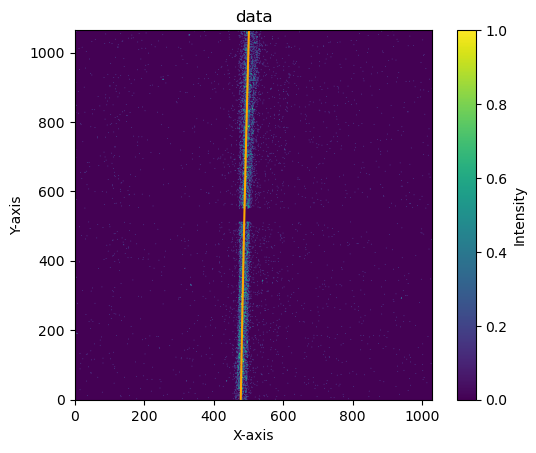

In [84]:
plt.imshow(img, origin='lower', cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='Intensity')
plt.title('data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

poly = fit_correction(img)
x_plot = np.linspace(0, h-1, 1000)
plt.plot(poly(x_plot),x_plot, '-', label='Polynomial fit', color="orange")
plt.show()


In [63]:
x = np.arange(l, dtype=np.float32)
y = np.arange(h, dtype=np.float32)
X = np.meshgrid(x, y)[0]


(1065, 1030) (1065, 1030)


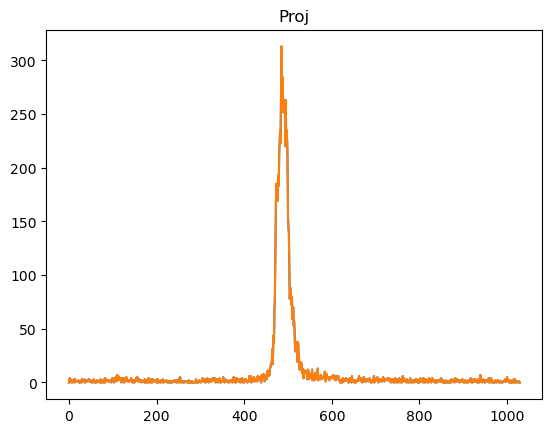

In [64]:
print(X.shape, img.shape)

proj_corrected = np.histogram(X.reshape(-1), weights=img.reshape(-1), bins=np.arange(img.shape[1]+1))[0]
proj = np.sum(img, axis=0)

plt.plot(proj)
plt.plot(proj_corrected)
plt.title('Proj')

plt.show()


(1065, 1030) (1065, 1030)


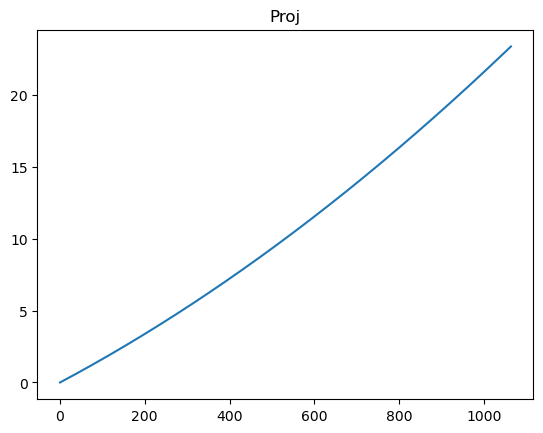

In [65]:
X = np.meshgrid(x, y)[0]
print(X.shape, img.shape)

correction = (poly(y) - poly[0]).reshape(-1, 1)
plt.plot(correction)
plt.title('Proj')

plt.show()


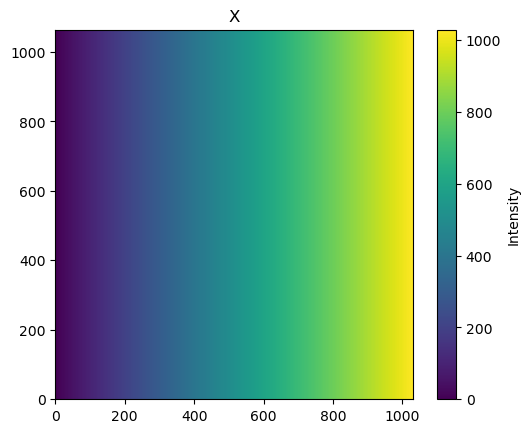

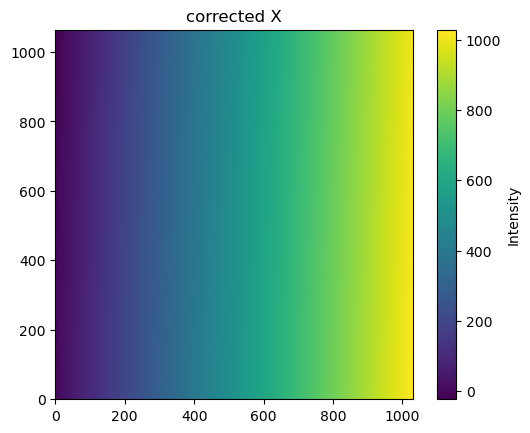

In [66]:
plt.imshow(X, origin='lower', cmap='viridis')
plt.colorbar(label='Intensity')
plt.title('X')
plt.show()
X -= correction
plt.imshow(X, origin='lower', cmap='viridis')
plt.colorbar(label='Intensity')
plt.title('corrected X')
plt.show()

(1065, 1030) (1065, 1030)


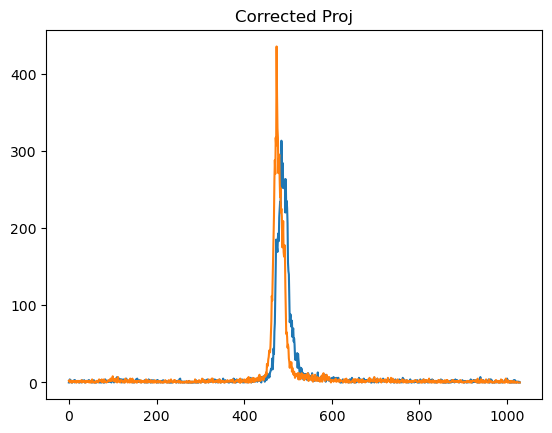

In [97]:
print(X.shape, img.shape)

proj_corrected = np.histogram(X.reshape(-1), weights=img.reshape(-1), bins=np.arange(img.shape[1]+1))[0]
proj = np.sum(img, axis=0)


# Plot the 2D Gaussian distribution
plt.plot(proj)
plt.plot(proj_corrected)
plt.title('Corrected Proj')
# plt.yscale('log')
plt.show()


In [94]:
hist = proj_corrected
bin_centers = np.arange(proj_corrected.shape[0])
mean = np.average(bin_centers, weights=hist)
rms = np.sqrt(np.average((bin_centers - mean)**2, weights=hist))
mean, rms

(495.2222852282393, 112.26918974243658)

In [107]:
params={
    "ROI_from": int(mean - rms),
    "ROI_to": int(mean + rms),
}

for i in range(poly.order+1):
    params[f"a{i}"] = poly[i]
params

{'ROI_from': 382,
 'ROI_to': 607,
 'a0': 477.8149177528423,
 'a1': 0.016944407251277903,
 'a2': 4.864087898507261e-06}

In [118]:
formatted_pars = []
for i, v in params.items():
    entry = {"name": str(i), "data": str(v)}
    formatted_pars.append(entry)
formatted_pars



[{'name': 'ROI_from', 'data': '382'},
 {'name': 'ROI_to', 'data': '607'},
 {'name': 'a0', 'data': '477.8149177528423'},
 {'name': 'a1', 'data': '0.016944407251277903'},
 {'name': 'a2', 'data': '4.864087898507261e-06'}]

In [120]:
with open("../params.json", "w") as f:
    f.write(json.dumps(formatted_pars))